# Packages install & import
Installing rdkit and pyg

In [1]:
%pip install rdkit-pypi


In [2]:
# Install PyTorch Geometric and its dependencies

import torch
pyg_url = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $pyg_url



Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Note: you may need to restart the kernel to use updated packages.


# Import

In [3]:
# Import necessary libraries

import sys
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx


In [4]:
!curl -O https://raw.githubusercontent.com/itakigawa/mpl_rdkit_utils/main/mpl_rdkit_utils.py

from mpl_rdkit_utils import DrawMolToMPL

# Function to plot molecular graphs using NetworkX and RDKit

def plot_mol_graph(graph, figsize=(8, 4), edge_label=True):
  g = to_networkx(graph, to_undirected=True)  #Convert PyG graph to NetworkX graph
  edge_dict = defaultdict(list)
  for i, e in enumerate(zip(*graph.edge_index.tolist())):
    u, v = e
    edge_dict[(u, v)].append(i)
    edge_dict[(v, u)].append(i)
  labels = {e: "{},{}".format(*edge_dict[e]) for e in g.edges}

  mol = graph.mol
  AllChem.Compute2DCoords(mol) # Compute 2D coordinates for the molecule
  pos = mol.GetConformers()[0].GetPositions()[:,:2]

  fig, ax = plt.subplots(1, 2, figsize=figsize)
  node_size=300
  nx.draw_networkx(g, pos, ax=ax[0], node_color='#eee', \
                   node_size=node_size, edgecolors='k')
  if edge_label:
    nx.draw_networkx_edge_labels(g, pos, ax=ax[0], edge_labels=labels,\
                                font_color='blue', rotate=False)
  dpi = plt.rcParams["figure.dpi"]
  node_radius = (node_size / 3.14159265359)**0.5 / dpi
  ax[0].set_axis_off()
  ax[0].set_aspect('equal')
  xmin, xmax = ax[0].get_xlim()
  ymin, ymax = ax[0].get_ylim()
  fs = min(*figsize)
  xr = node_radius * fs
  yr = node_radius * fs
  ax[0].set_xlim(xmin-xr, xmax+xr)
  ax[0].set_ylim(ymin-yr, ymax+yr)

  (xmin, xmax), (ymin, ymax) = DrawMolToMPL(mol, fig, ax[1])
  ax[1].set_xlim(xmin, xmax)
  ax[1].set_ylim(ymin, ymax)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  7540  100  7540    0     0  14193      0 --:--:-- --:--:-- --:--:-- 14253


# Data Loading

In [5]:
# Downloading data
infile_name = './input.smi'
key = "nr-arsmiles"
url = "https://tripod.nih.gov/tox21/challenge/download?id={}".format(key)
urllib.request.urlretrieve(url, infile_name)

# Load the data into a pandas DataFrame and then save it as CSV
df = pd.read_csv(infile_name, delim_whitespace=True, header=None)
df.columns = ['smiles', 'id', 'response']
df.to_csv('input.csv')

In [6]:
df.head()

,smiles,id,response
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0


In [7]:
df = pd.read_csv('input.csv', index_col=0)
# Convert a SMILES string to a molecule object and then we visualize it
smi = df['smiles'][9315]
mol = Chem.MolFromSmiles(smi)

In [8]:
smi


'OCCCO'

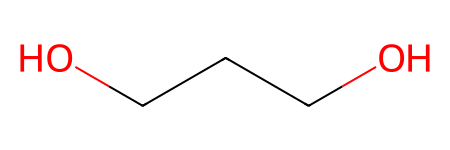

In [9]:
mol

In [10]:
df.shape

(9362, 3)

# Molecular Graphs for pyg

In [11]:
# Create edge indices for the molecular graph
edges = []
for bond in mol.GetBonds():
  i = bond.GetBeginAtomIdx()
  j = bond.GetEndAtomIdx()
  edges.extend([(i,j), (j,i)])

In [12]:
edge_index = list(zip(*edges))


In [13]:
edge_index


[(0, 1, 1, 2, 2, 3, 3, 4), (1, 0, 2, 1, 3, 2, 4, 3)]

In [14]:
# Functions to extract the features from atoms and bonds

def atom_feature(atom):
  return [atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetNumImplicitHs(),
          atom.GetIsAromatic()]

def bond_feature(bond):
  return [bond.GetBondType(),
          bond.GetStereo()]

In [15]:
# Extract node and edge features for the molecule
node_features = [atom_feature(a) for a in mol.GetAtoms()]
edge_features = [bond_feature(b) for b in mol.GetBonds()]

In [16]:
# Create a PyG Data object for the molecule

g = Data(edge_index=torch.LongTensor(edge_index),
         x=torch.FloatTensor(node_features),
         edge_attr=torch.FloatTensor(edge_features),
         smiles=smi,
         mol=mol)

In [17]:
g

Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 2], smiles='OCCCO', mol=<rdkit.Chem.rdchem.Mol object at 0x0000025E0F702650>)

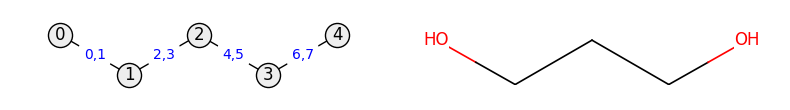

In [18]:
# Plot the molecular graph

plot_mol_graph(g)

In [19]:
# Function to convert a SMILES string to a PyG Data object

def smi_to_pyg(smi, y):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
      return None

    id_pairs = ((b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds())
    atom_pairs = [z for (i, j) in id_pairs for z in ((i, j), (j, i))]

    bonds = (mol.GetBondBetweenAtoms(i, j) for (i, j) in atom_pairs)
    atom_features = [atom_feature(a) for a in mol.GetAtoms()]
    bond_features = [bond_feature(b) for b in bonds]

    return Data(edge_index=torch.LongTensor(list(zip(*atom_pairs))),
                x=torch.FloatTensor(atom_features),
                edge_attr=torch.FloatTensor(bond_features),
                y=torch.LongTensor([y]),
                mol=mol,
                smiles=smi)

In [20]:
# Custom dataset class for PyG

class MyDataset(Dataset):
  def __init__(self, smiles, response):
    mols = [smi_to_pyg(smi, y) for smi, y in \
            tqdm(zip(smiles, response), total=len(smiles))]
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]

  def __len__(self):
    return len(self.X)

In [21]:
base_dataset = MyDataset(df['smiles'], df['response'])

  0%|          | 0/9362 [00:00<?, ?it/s]

[15:39:21] Explicit valence for atom # 3 Si, 8, is greater than permitted
[15:39:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[15:39:23] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[15:39:23] WARNING: not removing hydrogen atom without neighbors
[15:39:24] Explicit valence for atom # 3 Si, 8, is greater than permitted


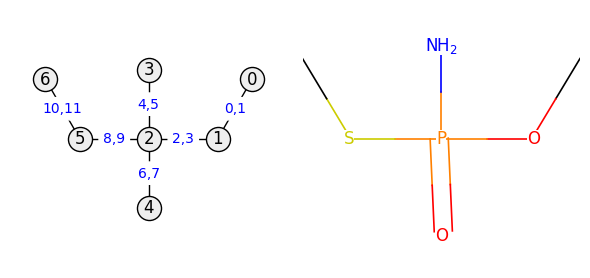

In [22]:
# Load a molecule graph from the dataset and plot it

g = base_dataset[8824]
plot_mol_graph(g, figsize=(6, 3), edge_label=True)

In [23]:
g

Data(x=[7, 4], edge_index=[2, 12], edge_attr=[12, 2], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x0000025E1A0E8430>, smiles='COP(N)(=O)SC')

In [24]:
g.x

tensor([[ 6.,  1.,  3.,  0.],
        [ 8.,  2.,  0.,  0.],
        [15.,  4.,  0.,  0.],
        [ 7.,  1.,  2.,  0.],
        [ 8.,  1.,  0.,  0.],
        [16.,  2.,  0.,  0.],
        [ 6.,  1.,  3.,  0.]])

In [25]:
g.edge_attr

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [2., 0.],
        [2., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [26]:
g.edge_index

tensor([[0, 1, 1, 2, 2, 3, 2, 4, 2, 5, 5, 6],
        [1, 0, 2, 1, 3, 2, 4, 2, 5, 2, 6, 5]])

# Train, Val & Test Split

In [27]:
N = len(base_dataset)
M = N // 10

indices = np.random.permutation(range(N))

idx = {'train': indices[:8*M],
      'valid': indices[8*M:9*M],
      'test': indices[9*M:]}

modes = ['train', 'valid', 'test']

In [28]:
dataset = {m: Subset(base_dataset, idx[m]) for m in modes}
loader = {m: DataLoader(dataset[m], batch_size=200, shuffle=True) if m == 'train' \
          else DataLoader(dataset[m], batch_size=200) for m in modes}

# ECFP4 + Random forest

In [29]:
# Random Forest with ECFP4 fingerprints

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [30]:
# Function to compute ECFP4 fingerprints

def ECFP4(mol):
  return np.asarray(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

In [31]:
# Prepare features and labels for Random Forest

X = {m: np.vstack([ECFP4(data.mol) for data in dataset[m]]) for m in modes}
y = {m: np.asarray([data.y.numpy() for data in dataset[m]]).flatten() for m in modes}

In [32]:
# Train and evaluate Random Forest model

model = RandomForestClassifier()
model.fit(X['train'], y['train'])

RandomForestClassifier()

In [33]:
for m in ['valid', 'test']:
  y_pred = model.predict(X[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y[m], y_pred)))

valid accuracy_score 0.979
valid balanced_accuracy_score 0.774
valid roc_auc_score 0.774
test accuracy_score 0.970
test balanced_accuracy_score 0.718
test roc_auc_score 0.718


# AttentiveFP Model

In [34]:
from torch_geometric.nn.models import AttentiveFP

In [35]:
# Get node and edge feature dimensions

node_dim = base_dataset[0].num_node_features
edge_dim = base_dataset[0].num_edge_features
node_dim, edge_dim

(4, 2)

In [36]:
# Use GPU if available else use CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [37]:
# Initialize AttentiveFP model

model = AttentiveFP(out_channels=2, # active or inactive
                    in_channels=node_dim, edge_dim=edge_dim,
                    hidden_channels=200, num_layers=3, num_timesteps=2,
                    dropout=0.2)
model = model.to(device)

In [38]:
train_epochs = 100
# Optimizer and loss function

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.CrossEntropyLoss()

In [39]:
# Functions to compute loss for training and validation

def train(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def test(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        _, predicted = torch.max(out.data, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred


In [40]:
best_val = float("inf")

#Training loop

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
          ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 020 Loss: train 0.000596 valid 0.000632 test 0.000794
Epoch: 040 Loss: train 0.000497 valid 0.000632 test 0.000743
Epoch: 060 Loss: train 0.000432 valid 0.000628 test 0.000739
Epoch: 080 Loss: train 0.000362 valid 0.000634 test 0.000775
Epoch: 100 Loss: train 0.000338 valid 0.000647 test 0.000790


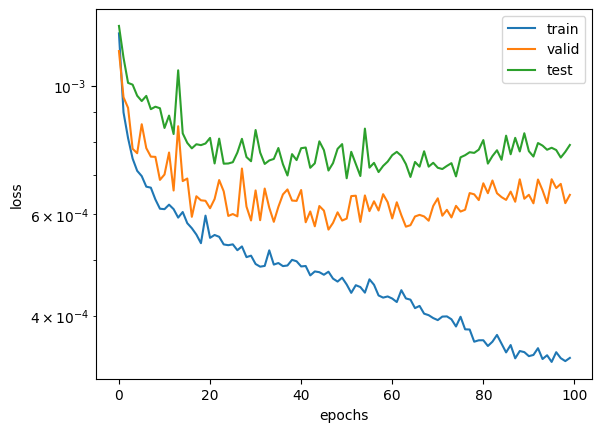

In [41]:
# Plot learning curves

fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [42]:
# Evaluate the model

model.load_state_dict(torch.load('best_val.model'))

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

valid accuracy_score 0.974
valid balanced_accuracy_score 0.748
valid roc_auc_score 0.748
test accuracy_score 0.970
test balanced_accuracy_score 0.708
test roc_auc_score 0.708


# GIN & GATV2 with Edge Attributes

In [43]:
from torch_geometric.nn import GINEConv, GATv2Conv, global_add_pool

In [44]:
# Function to create GIN or GAT convolution layers with edge attributes

def MyConv(node_dim, edge_dim, arch='GIN'):
  conv = None
  if arch == 'GIN':
    # GIN convolution with edge features
    h = nn.Sequential(nn.Linear(node_dim, node_dim, bias=True))
    conv = GINEConv(h, edge_dim=edge_dim)
  elif arch == 'GAT':
      # GAT convolution with edge features
    conv = GATv2Conv(node_dim, node_dim, edge_dim=edge_dim)
  return conv

In [45]:
# Custom GNN class using GIN or GAT convolution layers

class MyGNN(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3):
    super().__init__()

    # Create a list of convolution layers
    layers = [MyConv(node_dim, edge_dim, arch) for _ in range(num_layers)]
    self.convs = nn.ModuleList(layers)

  def forward(self, x, edge_index, edge_attr):
    # Apply each convolution layer followed by LeakyReLU activation
    for conv in self.convs:
      x = conv(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
    return x

In [46]:
# List of integer values for bond types
[int(x) for x in Chem.rdchem.BondType.names.values()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [47]:
# Periodic table information

ptable = Chem.GetPeriodicTable()
for i in range(200):
  try:
    s = ptable.GetElementSymbol(i)
  except:
    print(f'max id {i-1} for {s}')
    break
ptable.GetElementSymbol(i-1)

max id 118 for Og


[15:58:45] 

****
Pre-condition Violation
Atomic number not found
Violation occurred on line 99 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\PeriodicTable.h
Failed Expression: atomicNumber < byanum.size()
****



'Og'

In [48]:
# Custom network class with optional one-hot encoding or embedding

class MyFinalNetwork(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3,
               encoding='onehot'):
    super().__init__()

    self.encoding = encoding
    if encoding != 'onehot':
      # Use embeddings for atoms and bonds
      self.atom_encoder = nn.Embedding(num_embeddings=118+1, embedding_dim=64)
      self.bond_encoder = nn.Embedding(num_embeddings=21+1, embedding_dim=8)
      node_dim = (node_dim-1) + 64
      edge_dim = (edge_dim-1) + 8
    else:
      # Use one-hot encoding for atoms and bonds
      node_dim = (node_dim-1) + 118+1
      edge_dim = (edge_dim-1) + 21+1

    # Initialize GNN and fully connected layers
    self.gnn = MyGNN(node_dim, edge_dim, arch, num_layers=num_layers)
    embed_dim = int(node_dim / 2)
    self.head = nn.Sequential(
        nn.BatchNorm1d(node_dim),
        nn.Dropout(p=0.5),
        nn.Linear(node_dim, embed_dim, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(embed_dim),
        nn.Dropout(p=0.5),
        nn.Linear(embed_dim, 2)
    )
  def forward(self, x, edge_index, edge_attr, batch):
    if self.encoding == 'onehot':
      # One-hot encode atoms and bonds
      x0 = F.one_hot(x[:, 0].to(torch.int64), num_classes=118+1)
      edge_attr0 = F.one_hot(edge_attr[:, 0].to(torch.int64), num_classes=21+1)
    else:
      # Embed atoms and bonds
      x0 = self.atom_encoder(x[:, 0].int())
      edge_attr0 = self.bond_encoder(edge_attr[:, 0].int())

    # Concatenate features
    x = torch.cat([x0, x[:, 1:]], dim=1)
    edge_attr = torch.cat([edge_attr0, edge_attr[:, 1:]], dim=1)

    # Pass through GNN and global pooling
    node_out = self.gnn(x, edge_index, edge_attr)
    graph_out = global_add_pool(node_out, batch)
    return self.head(graph_out)

In [49]:
# Initialize the model
model = MyFinalNetwork(node_dim, edge_dim, arch='GAT', num_layers=3, encoding='embedding')
model = model.to(device)

In [50]:
# Training parameters

train_epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.CrossEntropyLoss()

In [51]:
# Initialize variables for tracking best validation loss and learning curve

best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

# Training loop
for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    # Save model if validation loss improves
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
          ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 020 Loss: train 0.002698 valid 0.002812 test 0.002816
Epoch: 040 Loss: train 0.000726 valid 0.000895 test 0.001030
Epoch: 060 Loss: train 0.000568 valid 0.000809 test 0.000799
Epoch: 080 Loss: train 0.000538 valid 0.000660 test 0.000770
Epoch: 100 Loss: train 0.000517 valid 0.000638 test 0.000800
Epoch: 120 Loss: train 0.000494 valid 0.000653 test 0.000792
Epoch: 140 Loss: train 0.000465 valid 0.000587 test 0.000745
Epoch: 160 Loss: train 0.000452 valid 0.000644 test 0.000767
Epoch: 180 Loss: train 0.000448 valid 0.000626 test 0.000705
Epoch: 200 Loss: train 0.000445 valid 0.000612 test 0.000737


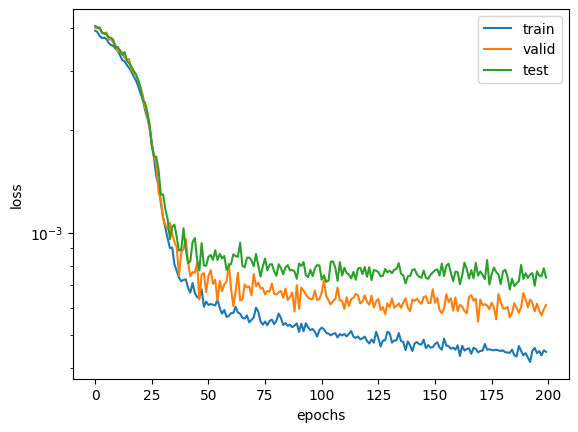

In [52]:
# Plot learning curves
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [53]:
# Load the best model
model.load_state_dict(torch.load('best_val.model'))

# Evaluate the model on validation and test sets
for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

valid accuracy_score 0.975
valid balanced_accuracy_score 0.736
valid roc_auc_score 0.736
test accuracy_score 0.966
test balanced_accuracy_score 0.686
test roc_auc_score 0.686
